In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [3]:
df=pd.read_csv(r"E:\HACKATHON MEDICAL SOLUTION\data\raw\Training.csv")

In [4]:
df

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(vertigo) Paroymsal Positional Vertigo,NaN
4916,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,Acne,NaN
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Urinary tract infection,NaN
4918,0,1,0,0,0,0,1,0,0,0,...,0,1,1,1,1,0,0,0,Psoriasis,NaN


In [5]:
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist()[:10], "...")  # show first 10 cols

Shape of dataset: (4920, 134)

Columns: ['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'ulcers_on_tongue'] ...


In [6]:
print("\nMissing values per column:")
print(df.isnull().sum().sum(), " total missing values")


Missing values per column:
4920  total missing values


In [7]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

Unnamed: 133    4920
dtype: int64


In [8]:
print("\nTarget distribution:")
df['prognosis'].value_counts()


Target distribution:


prognosis
Fungal infection                           120
Allergy                                    120
GERD                                       120
Chronic cholestasis                        120
Drug Reaction                              120
Peptic ulcer diseae                        120
AIDS                                       120
Diabetes                                   120
Gastroenteritis                            120
Bronchial Asthma                           120
Hypertension                               120
Migraine                                   120
Cervical spondylosis                       120
Paralysis (brain hemorrhage)               120
Jaundice                                   120
Malaria                                    120
Chicken pox                                120
Dengue                                     120
Typhoid                                    120
hepatitis A                                120
Hepatitis B                                120
Hep

In [9]:
# Remove the unwanted column
df = df.drop(columns=["Unnamed: 133"])


In [10]:
# Confirm it is removed
df.shape


(4920, 133)

In [11]:
print(df.isnull().sum().sum(), " total missing values after removal")


0  total missing values after removal


### OBSERVATION: No missing values in dataset .

Target Variable Analysis

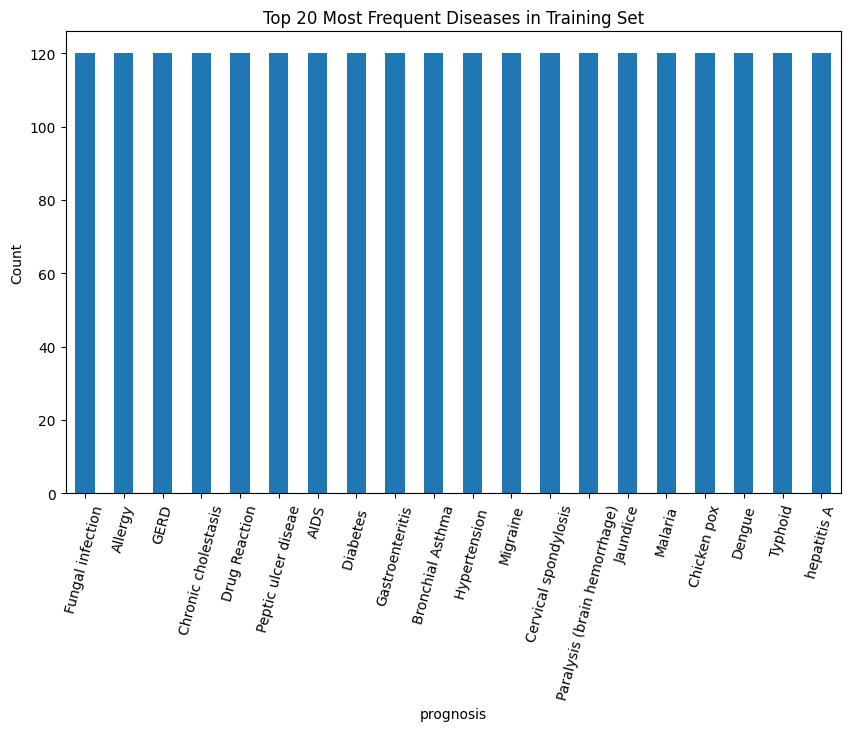

In [12]:
plt.figure(figsize=(10,6))
df['prognosis'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Most Frequent Diseases in Training Set")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()

3. Symptom sparsity

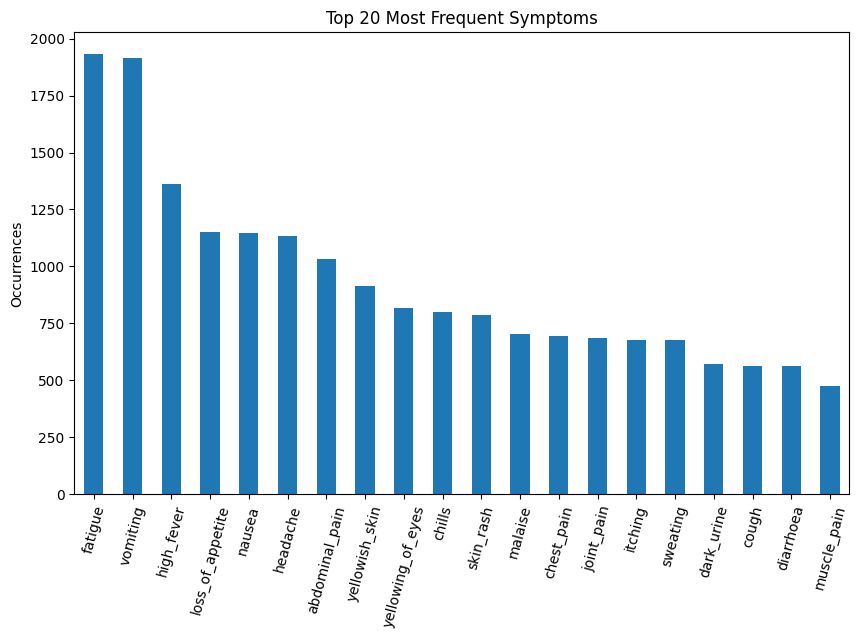

In [13]:
symptom_cols = [c for c in df.columns if c != 'prognosis']
symptom_sums = df[symptom_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
symptom_sums.head(20).plot(kind='bar')
plt.title("Top 20 Most Frequent Symptoms")
plt.ylabel("Occurrences")
plt.xticks(rotation=75)
plt.show()


### OBSERVATION: Few symptoms dominate (like 'vomiting', 'fatigue'), while many are rare.

Symptom correlation

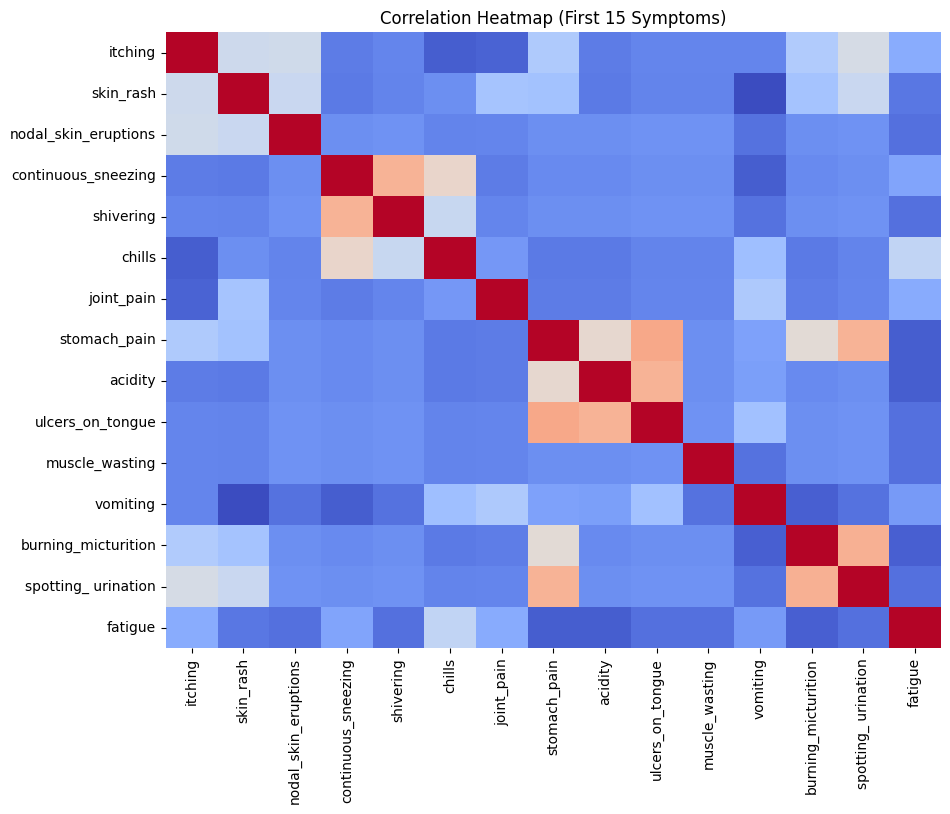

In [14]:
plt.figure(figsize=(10,8))
corr = df[symptom_cols].corr()
sns.heatmap(corr.iloc[:15,:15], cmap="coolwarm", cbar=False)
plt.title("Correlation Heatmap (First 15 Symptoms)")
plt.show()

### OBSERVATION: Some symptoms co-occur strongly (e.g., 'stomach_pain' with 'spotting_urination').

Number of symptoms per patient

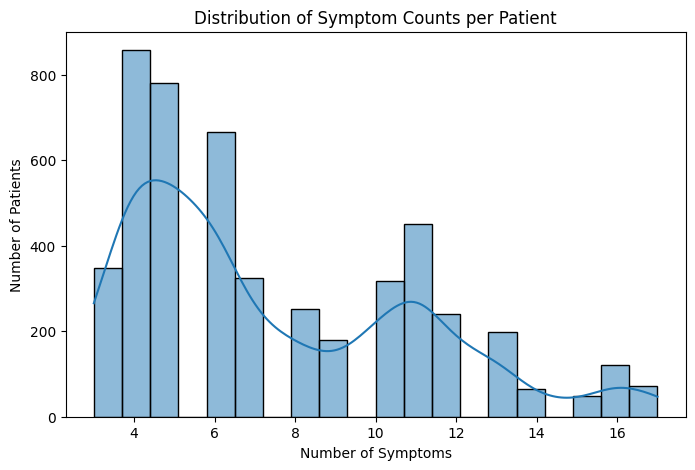

In [15]:
df['num_symptoms'] = df[symptom_cols].sum(axis=1)

plt.figure(figsize=(8,5))
sns.histplot(df['num_symptoms'], bins=20, kde=True)
plt.title("Distribution of Symptom Counts per Patient")
plt.xlabel("Number of Symptoms")
plt.ylabel("Number of Patients")
plt.show()

### Observation:Patients most commonly present with 3–6 symptoms, while cases with more than 10 symptoms are relatively rare.

Disease vs. average number of symptoms

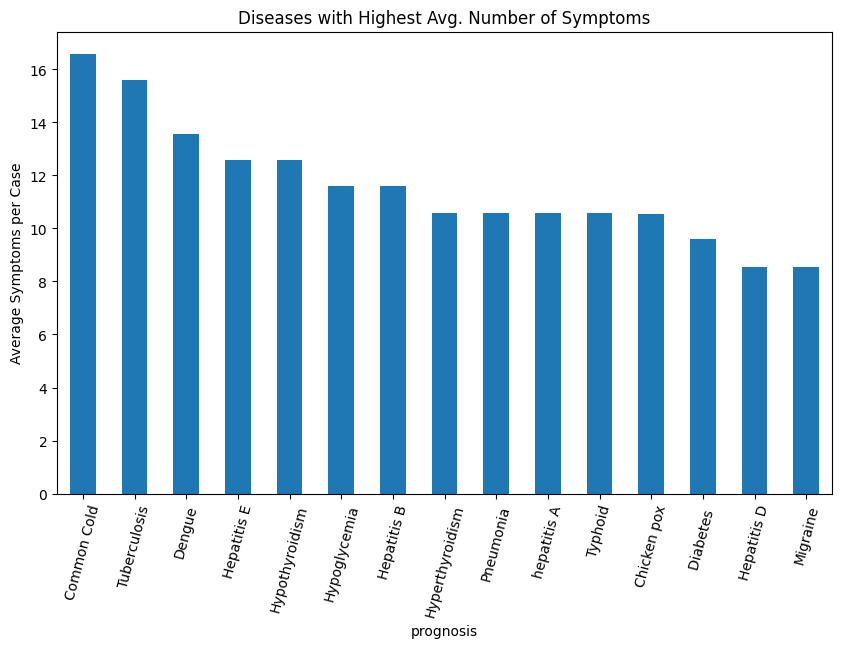

In [16]:
sym_count_per_disease = df.groupby('prognosis')['num_symptoms'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sym_count_per_disease.plot(kind='bar')
plt.title("Diseases with Highest Avg. Number of Symptoms")
plt.ylabel("Average Symptoms per Case")
plt.xticks(rotation=75)
plt.show()

### Observation: Common Cold, Tuberculosis, and Dengue show the highest average number of symptoms per case, indicating these diseases present with broader and more diverse symptom profiles compared to others like Migraine and Hepatitis D.

Class imbalance check

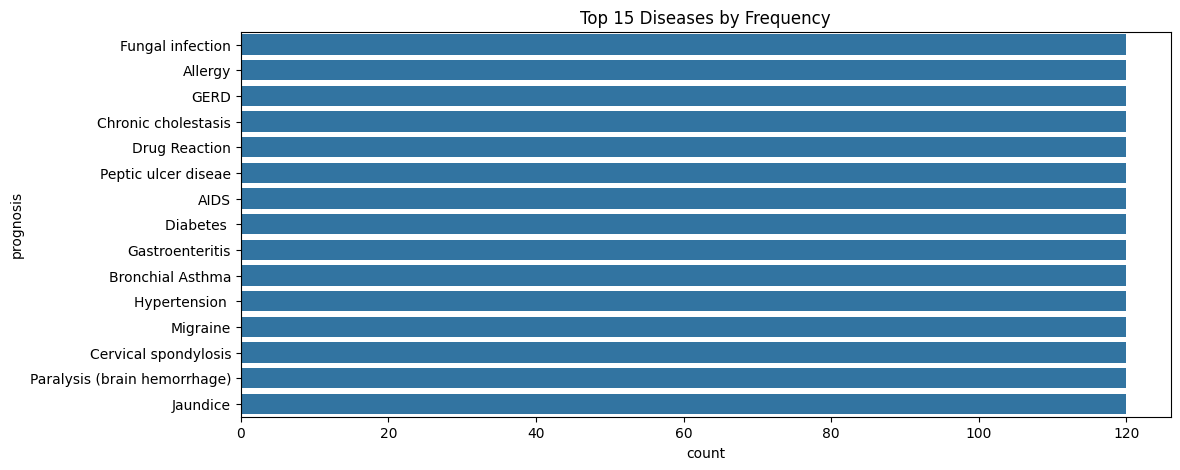

In [17]:
plt.figure(figsize=(12,5))
sns.countplot(y='prognosis', data=df, order=df['prognosis'].value_counts().index[:15])
plt.title("Top 15 Diseases by Frequency")
plt.show()

### Observation: The dataset is balanced

Check Duplicates

In [18]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 4616


### Observation: The dataset contains 4,616 duplicate rows.This is quite significant and indicates repetition of patient records or data redundancy.

Describe dataset

In [19]:
print("\n--- Numerical Summary ---")
df.describe()


--- Numerical Summary ---


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,num_symptoms
count,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,...,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000
mean,0.137805,0.159756,0.021951,0.045122,0.021951,0.162195,0.139024,0.045122,0.045122,0.021951,...,0.021951,0.021951,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171,7.448780
std,0.344730,0.366417,0.146539,0.207593,0.146539,0.368667,0.346007,0.207593,0.207593,0.146539,...,0.146539,0.146539,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461,3.592166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000


Rare symptoms (frequency count)

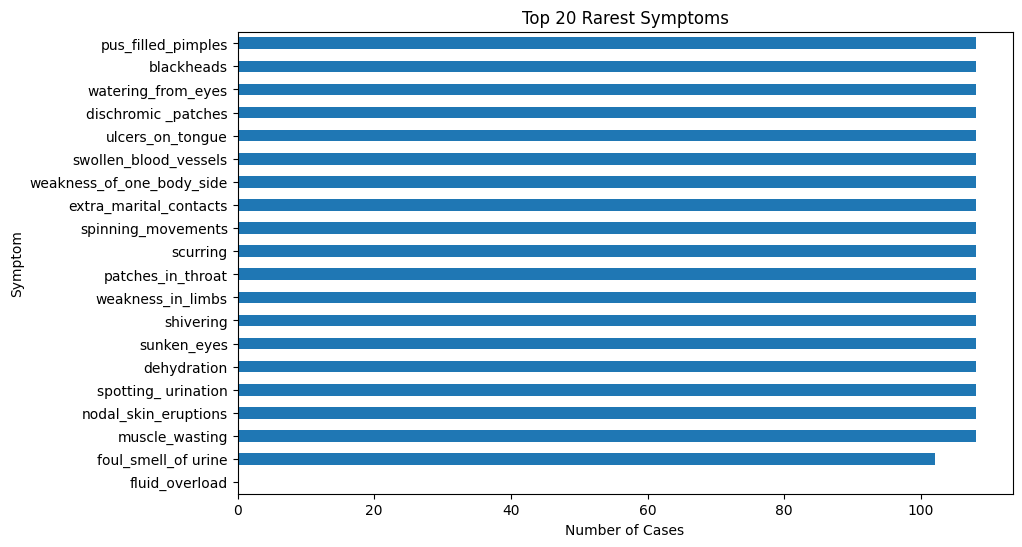

In [20]:
symptom_freq = df[symptom_cols].sum().sort_values(ascending=True)

plt.figure(figsize=(10,6))
symptom_freq.head(20).plot(kind='barh')
plt.title("Top 20 Rarest Symptoms")
plt.xlabel("Number of Cases")
plt.ylabel("Symptom")
plt.show()

### SPLITTING DATA 

In [22]:
train_df = df.drop(columns=["num_symptoms"])
test_df = pd.read_csv(r"E:\Downloads\archive (24)\Testing.csv")

In [23]:
X_train = train_df.drop("prognosis", axis=1)
y_train = train_df["prognosis"]

In [24]:
X_test = test_df.drop("prognosis", axis=1)
y_test = test_df["prognosis"]


In [25]:
X_train

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4916,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4918,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0


In [26]:
y_train

0                              Fungal infection
1                              Fungal infection
2                              Fungal infection
3                              Fungal infection
4                              Fungal infection
                         ...                   
4915    (vertigo) Paroymsal  Positional Vertigo
4916                                       Acne
4917                    Urinary tract infection
4918                                  Psoriasis
4919                                   Impetigo
Name: prognosis, Length: 4920, dtype: object

### Preprocesing

Encode target

In [27]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

Preprocessing Pipeline

In [28]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("pca", PCA(n_components=0.95))  
])

Fit on train & transform both train and test

In [29]:
X_train_pca = pipeline.fit_transform(X_train)
X_test_pca = pipeline.transform(X_test)

print("Before PCA:", X_train.shape)
print("After PCA:", X_train_pca.shape)

Before PCA: (4920, 132)
After PCA: (4920, 36)


### Model Training

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"🔹 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("="*60)


🔹 Logistic Regression Accuracy: 0.9762
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00      1.00      1.0

### Hyperparameter Tuning

In [31]:

# Define models and their parameter grids
param_grid = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ["l2"],   # l1 requires solver='liblinear'
            "solver": ["lbfgs", "saga"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "class_weight": [None, "balanced"]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "gamma": ["scale", "auto"],
            "kernel": ["rbf", "poly"],
            "class_weight": [None, "balanced"]
        }
    }
}

results = {}

# Run GridSearchCV for each model
for name, mp in param_grid.items():
    print(f"🔎 Tuning {name}...")
    grid = GridSearchCV(mp["model"], mp["params"], cv=3, scoring="f1_macro", n_jobs=-1)
    grid.fit(X_train_pca, y_train)
    
    # Best estimator
    best_model = grid.best_estimator_
    
    # Predict
    y_pred = best_model.predict(X_test_pca)
    
    # Accuracy & report
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"accuracy": acc, "best_params": grid.best_params_}
    
    print(f"✅ {name} Best Params: {grid.best_params_}")
    print(f"🔹 {name} Accuracy after tuning: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("="*60)

print("\n📊 Final Results:")
for name, res in results.items():
    print(f"{name}: Accuracy={res['accuracy']:.4f}, Best Params={res['best_params']}")

🔎 Tuning Logistic Regression...
✅ Logistic Regression Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
🔹 Logistic Regression Accuracy after tuning: 0.9762
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Ch

In [36]:
# Drop the target column
if "prognosis" in test_df.columns:
    test_df = test_df.drop(columns=["prognosis"])

# Take a few rows as demo
demo_df = test_df.sample(10, random_state=42)   # pick 10 random rows

# Save to demo.csv
demo_df.to_csv("demo.csv", index=False)

print("Demo file created: data/demo.csv")

Demo file created: data/demo.csv
